# import module

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MSE
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
import re
import numpy as np

In [5]:
nltk.download('stopwords')

base_dir = './data'

data = pd.read_csv(base_dir + '/PATIENT_DIAG_PROC.csv')

data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,SUBJECT_ID,HADM_ID,SEQ_NUM,diag_ICD,proc_ICD,DIAGNOSIS,diag_SHORT_TITLE,diag_LONG_TITLE,proc_SHORT_TITLE,proc_LONG_TITLE,solution
0,3,145834,2,78559,9962,HYPOTENSION,Shock w/o trauma NEC,Other shock without mention of trauma,Heart countershock NEC,Other electric countershock of heart,Shock w/o trauma NEC can be solved by Heart co...
1,3,145834,5,41071,3893,HYPOTENSION,"Subendo infarct, initial","Subendocardial infarction, initial episode of ...",Venous cath NEC,"Venous catheterization, not elsewhere classified","Subendo infarct, initial can be solved by Veno..."
2,3,145834,3,5849,8964,HYPOTENSION,Acute kidney failure NOS,"Acute kidney failure, unspecified",Pulmon art wedge monitor,Pulmonary artery wedge monitoring,Acute kidney failure NOS can be solved by Pulm...
3,3,145834,6,4280,966,HYPOTENSION,CHF NOS,"Congestive heart failure, unspecified",Entral infus nutrit sub,Enteral infusion of concentrated nutritional s...,CHF NOS can be solved by Entral infus nutrit s...
4,3,145834,1,0389,9604,HYPOTENSION,Septicemia NOS,Unspecified septicemia,Insert endotracheal tube,Insertion of endotracheal tube,Septicemia NOS can be solved by Insert endotra...


Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'diag_ICD', 'proc_ICD', 'DIAGNOSIS',
       'diag_SHORT_TITLE', 'diag_LONG_TITLE', 'proc_SHORT_TITLE',
       'proc_LONG_TITLE', 'solution'],
      dtype='object')


<Axes: xlabel='proc_ICD', ylabel='count'>

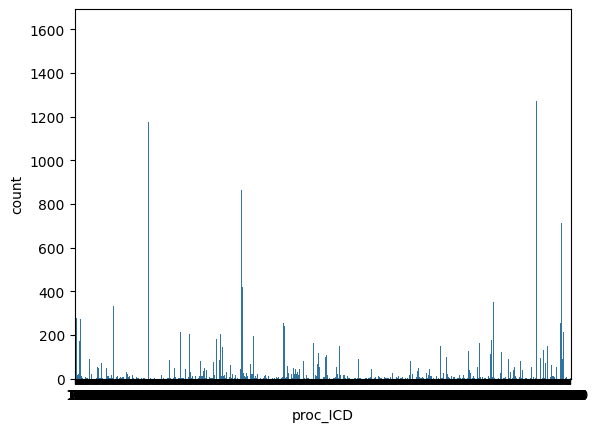

In [6]:
print(data.columns)

import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = data, stat="count", x="proc_ICD")

# 텍스트 데이터 셋 

In [7]:
# 텍스트 데이터 셋 생성
sentences_data = []
data['solution'].astype('str')
for idx in data['solution']:
    sentences_data.append(idx)

max_sentences_data = len(sentences_data)

sentences_data

['Shock w/o trauma NEC can be solved by Heart countershock NEC detailed description is Other electric countershock of heart.',
 'Subendo infarct, initial can be solved by Venous cath NEC detailed description is Venous catheterization, not elsewhere classified.',
 'Acute kidney failure NOS can be solved by Pulmon art wedge monitor detailed description is Pulmonary artery wedge monitoring.',
 'CHF NOS can be solved by Entral infus nutrit sub detailed description is Enteral infusion of concentrated nutritional substances.',
 'Septicemia NOS can be solved by Insert endotracheal tube detailed description is Insertion of endotracheal tube.',
 'Cardiac arrest can be solved by Cont inv mec ven 96+ hrs detailed description is Continuous invasive mechanical ventilation for 96 consecutive hours or more.',
 'Human immuno virus dis can be solved by Venous cath NEC detailed description is Venous catheterization, not elsewhere classified.',
 'Pneumocystosis can be solved by Dx ultrasound-heart detail

# 정규 표현식을 이용하여 특수 문자를 제거
 - lower() 작업을 통해 소문자 변환도 같이 해주었다.

In [8]:
# 모든 텍스트 소문자변환, 특수문자 정규표현식을 제거
def clean_text(texts):
    texts = re.sub(r'[^a-zA-Z\s]', '', texts)  
    texts = texts.lower()
    return texts

for num in range(len(sentences_data)):
    sentences_data[num] = clean_text(sentences_data[num])
sentences_data

['shock wo trauma nec can be solved by heart countershock nec detailed description is other electric countershock of heart',
 'subendo infarct initial can be solved by venous cath nec detailed description is venous catheterization not elsewhere classified',
 'acute kidney failure nos can be solved by pulmon art wedge monitor detailed description is pulmonary artery wedge monitoring',
 'chf nos can be solved by entral infus nutrit sub detailed description is enteral infusion of concentrated nutritional substances',
 'septicemia nos can be solved by insert endotracheal tube detailed description is insertion of endotracheal tube',
 'cardiac arrest can be solved by cont inv mec ven  hrs detailed description is continuous invasive mechanical ventilation for  consecutive hours or more',
 'human immuno virus dis can be solved by venous cath nec detailed description is venous catheterization not elsewhere classified',
 'pneumocystosis can be solved by dx ultrasoundheart detailed description is

# 불용어 제거
 - 문장에 의미가 없는 접속사와 접미사 등을 제거

In [9]:
stopword_list = set(stopwords.words('english'))
def del_stopword(texts):
    new_texts = ""
    words = texts.split()
    filtered_sentence = ""
    for word in words:
        if word not in stopword_list:
            filtered_sentence = filtered_sentence + word + " "
    new_texts += filtered_sentence
    return new_texts

del_sw_sentences_data = []
for num in range(max_sentences_data):
    del_sw_sentences_data.append(del_stopword(sentences_data[num]))

# 불용어 제거한 데이터 셋
del_sw_sentences_data

['shock wo trauma nec solved heart countershock nec detailed description electric countershock heart ',
 'subendo infarct initial solved venous cath nec detailed description venous catheterization elsewhere classified ',
 'acute kidney failure nos solved pulmon art wedge monitor detailed description pulmonary artery wedge monitoring ',
 'chf nos solved entral infus nutrit sub detailed description enteral infusion concentrated nutritional substances ',
 'septicemia nos solved insert endotracheal tube detailed description insertion endotracheal tube ',
 'cardiac arrest solved cont inv mec ven hrs detailed description continuous invasive mechanical ventilation consecutive hours ',
 'human immuno virus dis solved venous cath nec detailed description venous catheterization elsewhere classified ',
 'pneumocystosis solved dx ultrasoundheart detailed description diagnostic ultrasound heart ',
 'cachexia solved bronchoscopy detailed description bronchoscopy ',
 'surg compperi vasc syst solved r

# 문장을 시퀀스로 변환
 - 패딩 작업도 같이 해줌

In [10]:
# 문장 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(del_sw_sentences_data)
word_size = len(tokenizer.word_index) + 1

# 문장을 시퀀스로 변환
def make_to_sequence(texts):
    seq_sentences = []
    for sentence in texts:
        encoded = tokenizer.texts_to_sequences([sentence])[0]

        for i in range(1, len(encoded)):
            seq_sentences.append(encoded[:i+1])
    return seq_sentences

seq_sentence = make_to_sequence(del_sw_sentences_data)

seq_sentence[:7]

[[232, 37],
 [232, 37, 675],
 [232, 37, 675, 4],
 [232, 37, 675, 4, 1],
 [232, 37, 675, 4, 1, 6],
 [232, 37, 675, 4, 1, 6, 290],
 [232, 37, 675, 4, 1, 6, 290, 4]]

In [11]:
print(tokenizer.word_index)

{'solved': 1, 'detailed': 2, 'description': 3, 'nec': 4, 'nos': 5, 'heart': 6, 'cath': 7, 'biopsy': 8, 'catheterization': 9, 'insertion': 10, 'tube': 11, 'transfusion': 12, 'venous': 13, 'open': 14, 'closed': 15, 'infusion': 16, 'w': 17, 'cardiac': 18, 'insert': 19, 'tissue': 20, 'endoscopic': 21, 'excision': 22, 'oth': 23, 'fx': 24, 'repair': 25, 'ven': 26, 'incision': 27, 'ac': 28, 'mechanical': 29, 'ventilation': 30, 'endotracheal': 31, 'bone': 32, 'neo': 33, 'fracture': 34, 'invasive': 35, 'coronary': 36, 'wo': 37, 'percutaneous': 38, 'arteriography': 39, 'continuous': 40, 'injection': 41, 'artery': 42, 'skin': 43, 'cont': 44, 'dis': 45, 'inv': 46, 'mec': 47, 'hrs': 48, 'consecutive': 49, 'hours': 50, 'packed': 51, 'vessel': 52, 'intestine': 53, 'bronchoscopy': 54, 'lung': 55, 'substances': 56, 'graft': 57, 'spinal': 58, 'wound': 59, 'acute': 60, 'sub': 61, 'art': 62, 'liver': 63, 'chr': 64, 'lesion': 65, 'nutritional': 66, 'infus': 67, 'arterial': 68, 'vessels': 69, 'left': 70, 'n

# 패딩

In [12]:
# 패딩
max_sequences_len = max(len(string) for string in seq_sentence)
seq_sentence = np.array(pad_sequences(seq_sentence, maxlen=max_sequences_len, padding='pre'))

# 모든 배열 크기 확인
def check_array_size(arr):
    for i in range(10):
        print(len(arr[i]))

split_index = int(seq_sentence.shape[1] * 0.8)

# x : y = 22 : 6189
input_x = seq_sentence[:, :split_index]
target_y = seq_sentence[:, split_index:]
print(input_x.shape, target_y.shape)

(782826, 18) (782826, 5)


In [13]:
dims = 32

model = Sequential()
model.add(Embedding(word_size, dims))
model.add(Bidirectional(LSTM(max_sequences_len-1, return_sequences=True)))
model.add(Bidirectional(LSTM(max_sequences_len-1)))
model.add(Dense(word_size, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [14]:
print(tf.__version__)

2.9.0


In [15]:
record = model.fit(input_x, target_y, epochs=30)

Epoch 1/30


 3732/24464 [===>..........................] - ETA: 2:05 - loss: 9439792.0000 - accuracy: 0.2048

KeyboardInterrupt: 